# Inaugural Project

**Group members:** Ida Margrethe Stagsted, Julie Danneberg Voss, Ida Marie Krogh Jensen 


Imports and set magics:

In [89]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Importing modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import ipywidgets as widgets
from scipy import optimize
import scipy.stats as stats

# Import our class
from HouseholdSpecializationModel import HouseholdSpecializationModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1

When we want to see the $H_F/H_M$ ratio for different values of alpha and sigma we construct a table with the combination of the possible 9 values.

In [90]:
# Code for solving the model

from HouseholdSpecializationModel import HouseholdSpecializationModelClass as HC

alpha = [0.25, 0.50, 0.75]
sigma = [0.50, 1.00, 1.50]

function = HC() # Calls the functions/classes in our py-file

# Creates a table for alpha and sigma
def print_table(alpha, sigma): 
    
    # a. Empty text
    text = ''
    
    # b. Top header
    text += f'{"Combinations of alpha and sigma":3s}'
    text += '\n'
    for j, HF in enumerate(sigma):
       text += f'{j:6d}' 
    text += '\n'
    
    # c. Body
    for i, a in enumerate(alpha):
        if i > 0:
            text += '\n' 
        text += f'{i:3d} '
        for j, s in enumerate(sigma):
            function.par.alpha = a
            function.par.sigma = s
            HM = function.solve_discrete().HM
            HF = function.solve_discrete().HF
            text += f'{HF/HM:6.3f}'
    
    # d. Print
    print(text)

print_table(alpha,sigma)

/Users/idamariekroghjensen/Documents/Kandidat/2. semester/Intro to progr. and numerical anal. /projects-2023-julie-ida-ida-3/inauguralproject/HouseholdSpecializationModel.py:63: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/Users/idamariekroghjensen/Documents/Kandidat/2. semester/Intro to progr. and numerical anal. /projects-2023-julie-ida-ida-3/inauguralproject/HouseholdSpecializationModel.py:63: RuntimeWarning: invalid value encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/Users/idamariekroghjensen/Documents/Kandidat/2. semester/Intro to progr. and numerical anal. /projects-2023-julie-ida-ida-3/inauguralproject/HouseholdSpecializationModel.py:67: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


Combinations of alpha and sigma
     0     1     2
  0  0.545 0.308 0.214
  1  1.000 1.000 1.000
  2  1.833 3.250 4.667


**Conclusion**

Table 1 above indicates when alpha increase the ratio between hours working at home for male and female increase. However, if sigma increases the ratio between hours working at home for male and female decrease for alpha values 0.25 and 0.50, but when alpha = 0.75 the ratio will increase. 

# Question 2

For different values of women's wages we construct a plot for the log of hours working at home and log of wages for men and women. 

Note that since we know that wM is equal to 1 and therefore numeraire, we know that we can take log to wF instead of wF/wM.

In [91]:
# Code for solving the model
solution_wage = []

HM_wage_vec = ()
HF_wage_vec = ()
wF = (0.8, 0.9, 1.0, 1.1, 1.2)

# a. For loop
for wages in wF:
    function.par.wF = wages
    solution_wage.append(function.solve_discrete())

# b. Extracting results
HF_wage_vec = [ns.HF for ns in solution_wage]
HM_wage_vec = [ns.HM for ns in solution_wage]

H_ratio = [np.log(HF_ny/HM_ny) for HF_ny,HM_ny in zip(HF_wage_vec,HM_wage_vec)]
w_ratio = np.log(wF)

# c. Print
print(H_ratio)
print(w_ratio)


[2.0794415416798357, 1.6094379124341003, 1.540445040947149, 1.540445040947149, 1.466337068793427]
[-0.22314355 -0.10536052  0.          0.09531018  0.18232156]


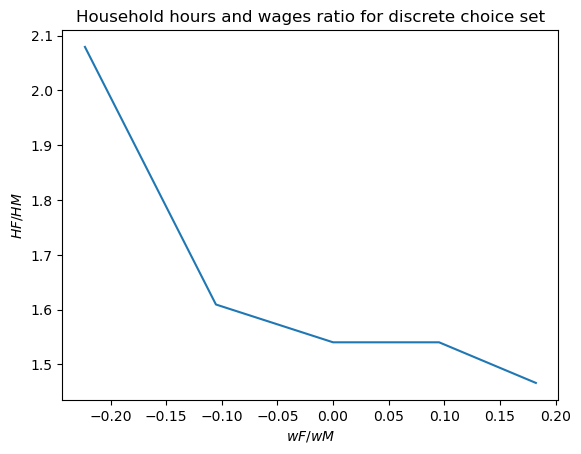

In [92]:
# Creating the figure
def plot_ratio():
    fig = plt.figure()

    # a. Create the plot
    ax = fig.add_subplot(1,1,1) 

    ax.plot(w_ratio,H_ratio)

    # b. Add labels
    ax.set_title('Household hours and wages ratio for discrete choice set')
    ax.set_xlabel('$wF/wM$')
    ax.set_ylabel('$HF/HM$')

# c. Print
plot_ratio()

**Conclusion**

The above figure illustrates that then $w_f$ increase the ratio between $log \frac{H_F}{H_M}$ decrease when time set is discrete in half hours

# Question 3

We now look at the same situation as above but now the time is continuous instead of discrete. 

The same conditions apply for wM and wF.

We use the SLSQP method when we optimize.

In [93]:
# Code for solving the  model
solution_con = []

wF = (0.8, 0.9, 1.0, 1.1, 1.2)

# a. For loop
for wages in wF:
    function_1 = HouseholdSpecializationModelClass()
    function_1.par.wF = wages
    solution_con.append(function_1.solve_con())

# b. Extracting results
HF_wage_vec_con = [ns[3] for ns in solution_con]
HM_wage_vec_con = [ns[2] for ns in solution_con]

H_ratio_con = [np.log(HF_a/HM_a) for HF_a, HM_a in zip(HF_wage_vec_con,HM_wage_vec_con)]
w_ratio_con = np.log(wF)

# c. Print
print(H_ratio_con)
print(w_ratio_con)


[0.2252006001808949, 9.754729058551197e-05, 2.154359799344263e-09, -8.680131447473675e-05, -0.18662683544420072]
[-0.22314355 -0.10536052  0.          0.09531018  0.18232156]


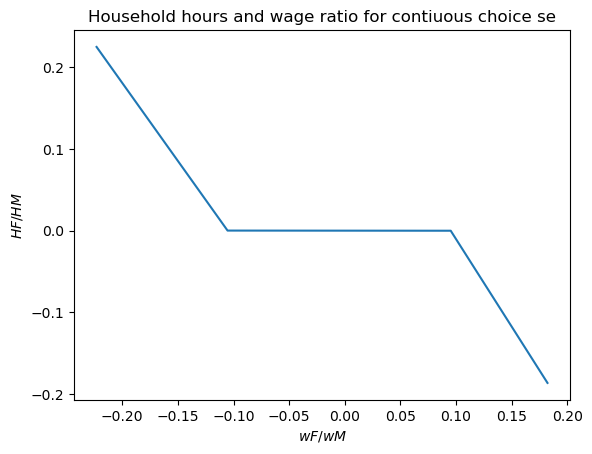

In [94]:
# Creating the figure
def plot_cont():
    fig = plt.figure()

    # a. Create the plot
    ax = fig.add_subplot(1,1,1) 

    ax.plot(w_ratio_con,H_ratio_con)

    # b. Add labels
    ax.set_title('Household hours and wage ratio for contiuous choice se')
    ax.set_xlabel('$wF/wM$')
    ax.set_ylabel('$HF/HM$')

# c. Print
plot_cont()

**Conclusion**

From the plot above we see that when wF is increasing, the $log \frac{H_F}{H_M}$ is decreasing, but when wF is between -0.10 and 0.10 the $log \frac{H_F}{H_M}$ will be equal to 0.0. 

# Question 4

As Siminski and Yetsenga (2022) finds, we set $\beta_0 \approx 0.4$ and $\beta_1 \approx -0.1$. 

We seek to find the values of $\alpha$ and $\sigma$ that minimizes $(\beta_0 - \hat\beta_0)^2 + (\beta_1 - \hat\beta_1)^2$.

wM will still be equal to 1 and wF will be in the interval 0.8 to 1.2.

We use the Nelder-Mead method when we optimize.


In [95]:
# Code for solving the model
def opt_alpha_sigma(parameters):
    
    # a. Calling the parameters from our py-file
    alpha, sigma = parameters 

    function_beta = HouseholdSpecializationModelClass() # Calls the functions/classes in out py-file

    # b. Parameters
    function_beta.par.alpha = alpha
    function_beta.par.sigma = sigma

    # c. Defining our slope and intercept using the ratios
    H_ratio, w_ratio = function_beta.ratio()
    slope, intercept, _, _, _ = stats.linregress(H_ratio,w_ratio)

    # d. Calculating
    beta0 = intercept
    beta1 = slope
    beta0_target = 0.4
    beta1_target = -0.1
    reg = (beta0_target - beta0)**2 + (beta1_target - beta1)**2
    return reg

# e. Bounds and guess
bounds_beta = [(1e-8,24-1e-8)]*2
guess_beta = (0.1, 0.2)

# f. Optimizing using Nelder-Mead method
result_beta = optimize.minimize(opt_alpha_sigma,
                                guess_beta,
                                method='Nelder-Mead',
                                bounds=bounds_beta)    
opt_alpha, opt_sigma = result_beta.x

# g. Print
print(opt_alpha, opt_sigma)

0.10709970221194504 0.38504357955243484


**Conclusion**

It means that when $\alpha = 0.1071$ and $\sigma = 0.3850$ it minimizes $(\beta_0 - \hat\beta_0)^2 + (\beta_1 - \hat\beta_1)^2$.